## Imports

In [55]:
import json
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.initializers import RandomUniform, RandomNormal, HeNormal, GlorotUniform
from keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2


dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search, grid_search_top_configs
from training.metrics import mean_euclidean_error
from training.solver import Solver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NN
In this notebook we implement and test a custom (feed-forward) Neural Network w.r.t. the tasks at hand, i.e. the three MONK's problem and the CUP dataset.

Specifically:
- **get_nn_classifier(...)**: defines the NN classifier for the MONK's problems;
- **get_nn_regressor(...)**: defines the NN regressor for the CUP dataset.

## Settings

In [3]:
MODEL_NAME = 'NN'
VAL_SPLIT = 0.2 # validation set percentage
INTERNAL_TEST_SPLIT = 0.5 # internal test split (50% of validation split)
RANDOM_STATE = 128 # reproducibility

## Path

In [4]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [5]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## Model

In [6]:
def get_nn_classifier(hparams):
    initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
    
    model = Sequential([
        Dense(hparams['h_dim'], activation='tanh', input_shape=(17,), kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(hparams['reg']))
    ])
    
    optimizer = SGD(learning_rate=hparams['lr'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mse'])
    return model

First of all, we define the grid search spaces for the RandomForestClassifier that we're going to use for all three MONK's problems.

## Training - Testing

In [73]:
hparams_m1 = {
    'lr': 0.1,
    'h_dim': 16,
    'reg': 0,
}

model_m1 = get_nn_classifier(hparams_m1)
solver = Solver(model_m1, x_dev_m1, y_dev_m1)
solver.train(epochs=5, patience=5, batch_size=32)

Epoch 1/5
4/4 [==============================] - 0s 2ms/step - loss: 0.7297 - accuracy: 0.4274 - mse: 0.2678
Epoch 2/5
4/4 [==============================] - 0s 2ms/step - loss: 0.7081 - accuracy: 0.5161 - mse: 0.2573
Epoch 3/5
4/4 [==============================] - 0s 2ms/step - loss: 0.6904 - accuracy: 0.5403 - mse: 0.2486
Epoch 4/5
4/4 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.5726 - mse: 0.2412
Epoch 5/5
4/4 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.6048 - mse: 0.2348
Restoring best model weights.
Best loss: 0.6621195077896118


In [7]:
print('-- DEVELOPMENT --')
loss_dev_m1, acc_dev_m1, mse_dev_m1 = model_m1.evaluate(x_dev_m1, y_dev_m1, batch_size=64)
print(f'Loss: {loss_dev_m1:.4f} - Accuracy: {acc_dev_m1:.4f} - MSE: {mse_dev_m1:.4f}')

-- DEVELOPMENT --
2/2 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5484 - mse: 0.2475
Loss: 0.6887 - Accuracy: 0.5484 - MSE: 0.2475


In [8]:
print('-- TEST --')
loss_test_m1, acc_test_m1, mse_test_m1 = model_m1.evaluate(x_test_m1, y_test_m1)
print(f'Loss: {loss_test_m1:.4f} - Accuracy: {acc_test_m1:.4f} - MSE: {mse_test_m1:.4f}')

-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.7301 - accuracy: 0.4884 - mse: 0.2671
Loss: 0.7301 - Accuracy: 0.4884 - MSE: 0.2671


## Store results

In [75]:
dev_report_m1 = {'loss': loss_dev_m1, 'accuracy': acc_dev_m1, 'mse': mse_dev_m1}
test_report_m1 = {'loss': loss_test_m1, 'accuracy': acc_test_m1, 'mse': mse_test_m1}

store_monk_result(results_dir + '/MONK1/', hparams_m1, dev_report_m1, test_report_m1)

# MONK-2

# MONK-3

# CUP

In [7]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

## Train-Val Split

In [8]:
x_train_cup, x_val_tmp_cup, y_train_cup, y_val_tmp_cup = train_test_split(
    x_dev_cup, y_dev_cup, test_size=VAL_SPLIT, random_state=128
)

## Val-Test Split
To comply with the **internal test** requirement of the project, we further split the validation data into validation and internal test, i.e. $50-50$ so that the final split of the development data is $80-10-10$.

In [9]:
x_val_cup, x_internal_test_cup, y_val_cup, y_internal_test_cup = train_test_split(
    x_val_tmp_cup, y_val_tmp_cup, test_size=INTERNAL_TEST_SPLIT, random_state=128  # 50% of 20% of validation set
)

## NN-SGD (no momentum)

In [20]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME + '/NN-SGD'

In [11]:
def get_nn_sgd_regressor(hparams):
    #initializer = RandomUniform(minval=-0.5, maxval=0.5)
    if hparams['activation'] == 'tanh':
        initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
    elif hparams['activation'] == 'ReLU':
        initializer = HeNormal(seed=RANDOM_STATE) # He (Kaiming)

        
    reg = l2(hparams['reg'])
        
    model = Sequential()
    model.add(Dense(
        hparams['h_dim'], 
        activation=hparams['activation'], 
        input_shape=(10,), 
        kernel_initializer=initializer)
    )

    h_dim = hparams['h_dim']
    for i in range(hparams['n_layers']):
        model.add(
            Dense(h_dim, activation=hparams['activation'], kernel_initializer=initializer))
        h_dim //= 2


    model.add(Dense(3, activation='linear', kernel_regularizer=l2(hparams['reg']), kernel_initializer=initializer))

    optimizer = SGD(learning_rate=hparams['lr'])
    model.compile(optimizer=optimizer, loss='mse', metrics=[mean_euclidean_error])
    return model

Here, we define the grid search spaces for the RandomForestRegression for the CUP dataset.

## Grid search

In [12]:
grid_search_spaces_cup = {
    'lr': [0.01, 0.001, 0.003, 0.006, 0.0001],
    'h_dim': [32, 64],
    'n_layers': [1, 2],
    'activation': ['ReLU'],
    'reg': [0.01, 0.001, 0.0001],
    'batch_size': len(x_dev_cup),
}

In [ ]:
grid_search(get_nn_sgd_regressor, x_train_cup, y_train_cup, x_val_cup, y_val_cup, grid_search_spaces_cup, TARGET='mean_euclidean_error', EPOCHS=300, PATIENCE=30)

In [ ]:
best_config['best_mee'] = min(results, key=lambda x: x[1]['val_mean_euclidean_error'])[1]['val_mean_euclidean_error']

# Store it
output_path = results_dir + '/CUP/' + 'best_config.json'
with open(output_path, 'w') as outf:
    json.dump(best_config, outf, indent=4)

## Training

In [ ]:
best_config = {
    'lr': 0.0035,
    'h_dim': 64,
    'n_layers': 1,
    'activation': 'ReLU',
    'reg': 0.01,
    'batch_size': len(x_train_cup),
}

model_nn_sgd_cup = get_nn_sgd_regressor(best_config)
solver = Solver(model_nn_sgd_cup, x_train_cup, y_train_cup, x_val_cup, y_val_cup, target='mean_euclidean_error')
solver.train(epochs=800, patience=50)

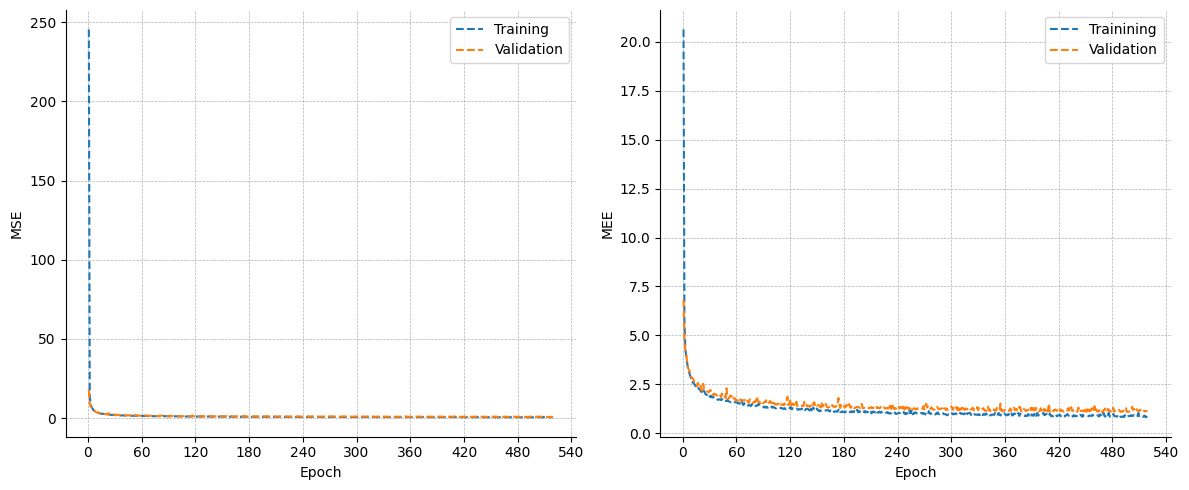

In [32]:
solver.plot_history(results_dir + '/CUP/history')

In [36]:
print('-- TRAINING --')
loss_train_cup, mee_train_cup = model_nn_sgd_cup.evaluate(x_train_cup, y_train_cup)
print(f'Loss: {loss_train_cup:.4f} -  MEE: {mee_train_m3:.4f}')

-- TRAINING --
25/25 [==============================] - 0s 1ms/step - loss: 0.5243 - mean_euclidean_error: 0.7897
Loss: 0.5243 -  MEE: 0.7897


In [37]:
print('-- VALIDATION --')
loss_val_cup, mee_val_cup = model_nn_sgd_cup.evaluate(x_val_cup, y_val_cup)
print(f'Loss: {loss_val_cup:.4f} -  MEE: {mee_val_m3:.4f}')

-- VALIDATION --
4/4 [==============================] - 0s 2ms/step - loss: 0.8215 - mean_euclidean_error: 1.0687
Loss: 0.8215 -  MEE: 1.0687


In [38]:
print('-- INTERNAL TEST --')
loss_internal_test_cup, mee_internal_test_cup = model_nn_sgd_cup.evaluate(x_internal_test_cup, y_internal_test_cup)
print(f'Loss: {loss_internal_test_cup:.4f} -  MEE: {mee_internal_test_cup:.4f}')

-- INTERNAL TEST --
4/4 [==============================] - 0s 2ms/step - loss: 1.1028 - mean_euclidean_error: 1.2042
Loss: 1.1028 -  MEE: 1.2042


## Blind Test Predictions

In [ ]:
# Blind test set predictions
nn_sgd_preds_cup = model_nn_sgd_cup.predict(x_test_cup)

29/29 [==============================] - 0s 1ms/step


## Store Result

In [56]:
report_nn_sgd = {
    'train': {'mse_loss': loss_train_cup, 'mse': mee_train_cup},
    'val': {'mse_loss': loss_val_cup, 'mse': mee_val_cup},
    'internal_test': {'mse_loss': loss_internal_test_cup, 'mee': mee_internal_test_cup}
}

store_cup_result(results_dir + '/CUP/', report_nn_sgd, nn_sgd_preds_cup)